In [8]:
#NLP
import spacy
nlp = spacy.load("es_core_news_sm")
from spacy.lang.es.stop_words import STOP_WORDS
from spacy.lang.es import Spanish
import string

#SKLEARN
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.linear_model import LogisticRegression # Regresion Logística

# Data manipulation
from imblearn.under_sampling import RandomUnderSampler
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt
from tqdm import tqdm


In [2]:
df = pd.read_csv("topics.csv",sep=',',error_bad_lines=False)
df.drop(['Unnamed: 0'], axis = 1, inplace=True) # Para suprimir la columna ID
df.drop(columns=['text','media_outlet', 'url','topic'], inplace=True)

df = df.astype({"label": str})
df.replace("0.0","mundo", inplace=True)
df.replace("1.0","economia", inplace=True)
df.replace("2.0","politica", inplace=True)
df.replace("3.0","ciencia", inplace=True)
df.replace("6.0","deporte", inplace=True)
df.replace("8.0","crimen", inplace=True)
df.replace("9.0","salud", inplace=True)

df

,content,label
0,Edificio se inunda tras rotura de piscina en C...,politica
1,"Trump visita Kenosha y califica de ""terrorismo...",ciencia
2,El secreto detalle en la vestimenta de Pablo E...,ciencia
3,Extraño tiburón sin piel es avistado nadando e...,ciencia
4,"""Melania y yo"": La exmejor mejor amiga revela ...",ciencia
...,...,...
69308,"Paris destaca caída ""moderada"" de casos, pero ...",salud
69309,Diputado Ilabaca (PS) critica al Gobierno por ...,politica
69310,Provoste se distancia de anuncio del President...,politica
69311,"Vacunas CanSino, que requieren una sola dosis,...",salud


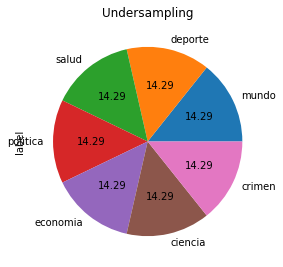

In [6]:
dfc = df[df['label']!="5.0"]
dfc = dfc[dfc['label']!="7.0"]
undersample = RandomUnderSampler(random_state=0)
x_res,y_res = undersample.fit_resample(dfc,dfc['label'])
fig, ax = plt.subplots(figsize=(4,4),tight_layout=True)
ax = y_res.value_counts().plot.pie(autopct='%.2f')
_ = ax.set_title("Undersampling")
plt.show()

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_res['content'],y_res, test_size=0.5)

In [24]:
# Create our list of punctuation marks
punctuations = [".",",","!","?", "#","&"]

# Create our list of stopwords
stop_words=[""]

# Load English tokenizer, tagger, parser, NER and word vectors
parser = Spanish()

# Creating our tokenizer function
def spacy_tokenizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = parser(sentence)

    # Lemmatizing each token and converting each token into lowercase
    mytokens = [word.lower_ for word in mytokens]
        
    # Removing stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    # return preprocessed list of tokens
    return mytokens

In [25]:
bow_vector = CountVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,1))
bow_vector

CountVectorizer(tokenizer=<function spacy_tokenizer at 0x7f9c82d75700>)

In [26]:
tfidf_vector = TfidfVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,1))

In [28]:
from sklearn.ensemble import RandomForestClassifier
modelRF = RandomForestClassifier(random_state=0)

model3 = Pipeline([('preprocessing', bow_vector),
                 ('regression-ML', modelRF)])

# model generation
model3.fit(X_train,y_train)

Pipeline(steps=[('preprocessing',
                 CountVectorizer(tokenizer=<function spacy_tokenizer at 0x7f9c82d75700>)),
                ('regression-ML', RandomForestClassifier(random_state=0))])

In [32]:
# Predicting with a test dataset
predicted = model3.predict(X_test)
print(predicted)

# Model Accuracy
print("Logistic Regression Accuracy:",metrics.accuracy_score(y_test, predicted))
print("Logistic Regression Precision:",metrics.precision_score(y_test, predicted, 
                                           average='micro'))
print("Logistic Regression Recall:",metrics.recall_score(y_test, predicted, 
                                           average='micro'))

['economia' 'crimen' 'politica' ... 'politica' 'ciencia' 'economia']
Logistic Regression Accuracy: 0.6249832641585219
Logistic Regression Precision: 0.6249832641585219
Logistic Regression Recall: 0.6249832641585219


In [33]:
#Evaluación del rendimiento del clasificador
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, predicted)
print(confusion_matrix)

#Print de la matriz de confusión
from sklearn.metrics import classification_report
print(classification_report(y_test, predicted))



[[568 115 123  74  59  92  68]
 [ 13 918  36   9  12  51  12]
 [ 26 104 551 131  59  90 100]
 [ 28  83 119 610  58  83  73]
 [111 115 153  96 357 107 143]
 [ 83 105  60  41  63 687  35]
 [ 13  14   9   7  14  14 977]]
              precision    recall  f1-score   support

     ciencia       0.67      0.52      0.59      1099
      crimen       0.63      0.87      0.73      1051
     deporte       0.52      0.52      0.52      1061
    economia       0.63      0.58      0.60      1054
       mundo       0.57      0.33      0.42      1082
    politica       0.61      0.64      0.63      1074
       salud       0.69      0.93      0.80      1048

    accuracy                           0.62      7469
   macro avg       0.62      0.63      0.61      7469
weighted avg       0.62      0.62      0.61      7469



              precision    recall  f1-score   support

     ciencia      0.675     0.517     0.585      1099
      crimen      0.631     0.873     0.733      1051
     deporte      0.524     0.519     0.522      1061
    economia      0.630     0.579     0.603      1054
       mundo      0.574     0.330     0.419      1082
    politica      0.611     0.640     0.625      1074
       salud      0.694     0.932     0.796      1048

    accuracy                          0.625      7469
   macro avg      0.620     0.627     0.612      7469
weighted avg      0.620     0.625     0.611      7469



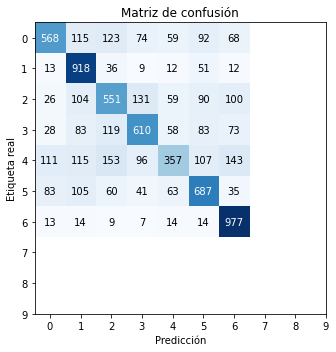

In [37]:
from sklearn.metrics import confusion_matrix, classification_report

def plot_confusion_matrix(cm, labels, cmap=plt.cm.Blues):
    fig, ax = plt.subplots(figsize=(5, 5), tight_layout=True)
    ax.imshow(cm, interpolation='nearest', cmap=cmap)
    for i in range(cm.shape[1]):
        for j in range(cm.shape[0]):
            ax.text(j, i, "{:,}".format(cm[i, j]), 
                    horizontalalignment="center", verticalalignment="center",
                    color="white" if cm[i, j] > np.amax(cm)/2 else "black")
    ax.set_title("Matriz de confusión")
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels)
    plt.yticks(tick_marks, labels)
    plt.ylabel('Etiqueta real')
    plt.xlabel('Predicción')

cm = confusion_matrix(y_true=y_test, y_pred=predicted)
plot_confusion_matrix(cm, labels=[str(i) for i in range(10)])
print(classification_report(y_test, predicted, digits=3))